# Inspector

The `Inspector` class uses the [Pandas](https://pandas.pydata.org/) library to aggregate information during a seismic inversion from ASDFDataSets. 

This information includes source and receiver metadata and relationships (source--receiver distance, backazimuth), misfit window information, and adjoint source information. Measurements are stored down to the level of a single misfit window on a given component of a source--receiver pair. 

Direct access to this aggregated information facilitates the generation useful statistics and plots with the goal of better understanding misfit within a single iteration, or over the course of the inversion. 

Some pre-defined functions allow quick access to useful inversion information, while the underlying DataFrame object provides all the power of the Pandas library to be used for assessing misfit and time windows for an inversion.

In [4]:
from pyatoa import Inspector

## Preparation
The `Inspector` class searches for ASDFDataSets to aggregate data from. These datasets are usually created during a seismic inversion. For example, running SeisFlows3 + Pyaflowa will generate datasets at each evaluation of the misfit function (!!! Add link to this page). For this short example, we will manually fill a dataset to illustrate the `Inspector` initialization routine.

In [6]:
# This code block initiates an ASDFDataSet with waveform and metadata, to illustrate 
# the Inspector
import os
import obspy
from pyasdf import ASDFDataSet
from pyatoa import Config, Manager, logger
logger.setLevel("INFO")

# Read in teset waveform data and metadata
inv = obspy.read_inventory("../tests/test_data/test_dataless_NZ_BFZ.xml")
cat = obspy.read_events("../tests/test_data/test_catalog_2018p130600.xml")
event = cat[0]
st_obs = obspy.read("../tests/test_data/test_obs_data_NZ_BFZ_2018p130600.ascii")
st_syn = obspy.read("../tests/test_data/test_syn_data_NZ_BFZ_2018p130600.ascii")

# The Manager class can fill up a dataset with the write() function. Processing results
# accumulated during the flow() function automatically write to the dataset.
ds_fid = "../tests/test_data/docs_ASDFDataSet.h5"

if os.path.exists(ds_fid):
    os.remove(ds_fid)
    
with ASDFDataSet(ds_fid) as ds:
    cfg = Config(iteration=1, step_count=0)
    mgmt = Manager(ds=ds, config=cfg, inv=inv, event=event, st_obs=st_obs, st_syn=st_syn)
    mgmt.write()
    mgmt.flow()


[2022-02-23 12:52:13] - pyatoa - INFO: standardizing streams
[2022-02-23 12:52:13] - pyatoa - INFO: preprocessing observation data
[2022-02-23 12:52:13] - pyatoa - INFO: adjusting taper to cover time offset -20.0
[2022-02-23 12:52:13] - pyatoa - INFO: preprocessing synthetic data
[2022-02-23 12:52:13] - pyatoa - INFO: adjusting taper to cover time offset -20.0
[2022-02-23 12:52:13] - pyatoa - INFO: running Pyflex w/ map: default
[2022-02-23 12:52:13] - pyatoa - INFO: 1 window(s) selected for comp E
[2022-02-23 12:52:13] - pyatoa - INFO: 1 window(s) selected for comp N
[2022-02-23 12:52:14] - pyatoa - INFO: 1 window(s) selected for comp Z
[2022-02-23 12:52:14] - pyatoa - INFO: 3 window(s) total found
[2022-02-23 12:52:14] - pyatoa - INFO: 0.365 misfit for comp E
[2022-02-23 12:52:14] - pyatoa - INFO: 1.620 misfit for comp N
[2022-02-23 12:52:14] - pyatoa - INFO: 0.004 misfit for comp Z
[2022-02-23 12:52:14] - pyatoa - INFO: total misfit 1.989


## Initializing and data discovery

The `Inspector` class will automatically search for data with the `discover` function. An optional `tag` is used for output filenames. If `tag` is not set, the tag will use the name `default`. 

During data discovery function, the `Inspector` retrieves source and receiver metadata, misfit windows information (e.g., starttimes, time shifts, amplitude anomalies etc.), adjoint source information (e.g., total misfit). 

These data are stored in a Pandas dataframe and uniquely labelled by keyword (e.g., iteration, event id, station name, component) so that they are easily accessible.

In [7]:
# Initialize the Inspector and discover all available datasets (of which there is only 1)
insp = Inspector(tag="default", verbose=True)
insp.discover(path="../tests/test_data")
# Remove dataset from test data to avoid large fileset in the repo
os.remove(ds_fid)
print(insp)

test_ASDFDataSet.h5       001/001...done
1    event(s)
1    station(s)
1    iteration(s)
1    evaluation(s)


## Accessing data within the Inspector

Let's see how we can access the information that was collected during the data discover phase. 
There are two main categories here: metadata and measurement data

### Source and receiver metadata
-----------------------------------

A list of event ids and station names can be accessed through the `events` and `stations` attributes, respectfully. Metadata, including locations and source information like magnitude and origint time are accesible through the `sources` and `receivers` attributes. The `srcrcv` attribute provides information relating to each source-receiver pair.

In [5]:
# The `events` attributes simply lists all event ids (pulled from QuakeML resource IDs)
insp.events

array(['2018p130600'], dtype=object)

In [7]:
# The `stations` attributes lists receiver names (without network codes)
insp.stations

array(['BFZ'], dtype=object)

In [9]:
# `sources` provides more detailed event information, including origin time, hypocentral location, and magnitude.
insp.sources

,time,magnitude,depth_km,latitude,longitude
event_id,,,,,
2018p130600,2018-02-18T07:43:48.127644Z,5.156706,20.594599,-39.948975,176.299515


In [11]:
# `receivers` provides more detailed station information, with network code and location
insp.receivers

,,latitude,longitude
network,station,,
NZ,BFZ,-40.679647,176.246245


In [16]:
# The `srcrcv` attribute provides information relating to source-receiver pairs
# including epicentral distance and backazimuth. Each pair will get a row in this dataframe.
insp.srcrcv

,event,network,station,distance_km,backazimuth
0,2018p130600,NZ,BFZ,81.260637,3.211526


### Measurement data from misfit windows
--------------------------------------------

During an inversion, Pyatoa (via Pyflex and Pyadjoint) collects information from each misfit window and adjoint source. The Inspector aggregates and labels all this information within a Pandas dataframe so that it is easily accesible. Information is stored in the `windows` attribute. 

Each row in the `window` attribute corresponds to a single misfit window, which in turn is related to a component, station, event, and iteration. Since the `windows` attribute is simply a Pandas dataframe, all standard Pandas operations can be used to access data.

In [17]:
insp.windows

,event,iteration,step,network,station,channel,component,misfit,length_s,dlnA,window_weight,max_cc_value,relative_endtime,relative_starttime,cc_shift_in_seconds,absolute_starttime,absolute_endtime
0,2018p130600,i01,s00,NZ,BFZ,HHE,E,0.365397,62.76,-0.709653,5.469764,0.871537,77.07,14.31,1.08,2018-02-18T07:43:42.437644Z,2018-02-18T07:44:45.197644Z
1,2018p130600,i01,s00,NZ,BFZ,HHN,N,1.620000,39.15,-0.828518,3.882748,0.991762,77.07,37.92,1.89,2018-02-18T07:44:06.047644Z,2018-02-18T07:44:45.197644Z
2,2018p130600,i01,s00,NZ,BFZ,HHZ,Z,0.004050,21.21,-0.903363,2.101535,0.990823,41.46,20.25,0.00,2018-02-18T07:43:48.377644Z,2018-02-18T07:44:09.587644Z


In [18]:
# Rows in the `windows` dataframe are accessible via array indexing
insp.windows.iloc[0]

event                                  2018p130600
iteration                                      i01
step                                           s00
network                                         NZ
station                                        BFZ
channel                                        HHE
component                                        E
misfit                                    0.365397
length_s                                     62.76
dlnA                                     -0.709653
window_weight                             5.469764
max_cc_value                              0.871537
relative_endtime                             77.07
relative_starttime                           14.31
cc_shift_in_seconds                           1.08
absolute_starttime     2018-02-18T07:43:42.437644Z
absolute_endtime       2018-02-18T07:44:45.197644Z
Name: 0, dtype: object

In [20]:
# Each of these series can in turn be queried for specific attributes
insp.windows.iloc[0].absolute_starttime

'2018-02-18T07:43:42.437644Z'

In [23]:
# The User can query a single column, e.g., to get all cc values in a list. Pandas is great:)
insp.windows["max_cc_value"]

0    0.871537
1    0.991762
2    0.990823
Name: max_cc_value, dtype: float64

In [24]:
# Which in turn can be operated on like numpy arrays (or Pandas series)
insp.windows["max_cc_value"].mean()

0.95137376274536101

### Misfits and window number
----------------------

The `Inspector` has some useful functions for calculating the misfit (`misfit`) for various levels (per function evaluation, per station, per event) and the number of misfit windows (`nwin`) for various levels. These functions are useful for looking at larger-scale changes within the inversion, e.g., when creating convergence plots showing misfit reduction per iteration, or for understanding how a new set of parameters affected the total amount of the dataset measured.

### Misfits

The equations for misfit for a single earthquake and for a single iteration are defined by Equations 6 and 7, respectively from [Tape et al., (2010)](https://academic.oup.com/gji/article/180/1/433/600143). These are automatically calculated by the Inspector when you call the `misfit` function. The resulting dataframe rows are given for each line search step within an iteration. 

In [29]:
# !!! Note: 
# The summed_misfit and misfit are the same here because we only have 1 event
# misfit = summed_misfit / n_event
insp.misfit()

,,n_event,summed_misfit,misfit
iteration,step,,,
i01,s00,1,0.331575,0.331575


In [31]:
# We can change the level to look at a per-event misfit. Misfit is scaled by the number of windows per event
insp.misfit(level="event")

,,,unscaled_misfit,nwin,misfit
iteration,step,event,,,
i01,s00,2018p130600,1.989447,3,0.331575


In [32]:
# We can also look at a per-station misfit
insp.misfit(level="station")

,,,,unscaled_misfit,nwin,misfit
iteration,step,event,station,,,
i01,s00,2018p130600,BFZ,1.989447,3,0.663149


### Number of Windows
--------------------------
It is usually useful to know the number of measurement windows you have, useful as a proxy for how good your data is, or how well-suited your windowing parameters are for a given dataset. This information is accessible through the `nwin` function. As with the `misfit` function, the User can select the level at which they want this information.

I have also found it useful to look at the cumulative window length (`length_s`). The reasoning behind this is that as one looks at shorter periods (higher frequencies), window lengths become shorter to accomdate higher-frequency phases. In other words, one long window can be chopped into many smaller windows, while still covering the same section of the waveform. `length_s` therefore provides another value that can be compared between iterations.

In [33]:
# `nwin` will return both the number of windows, and the cumulative window length
insp.nwin()

,,nwin,length_s
iteration,step,,
i01,s00,3,123.12


In [34]:
# Again, we can make choices about the level at which we want this information
insp.nwin(level="event")

,,,nwin,length_s
iteration,step,event,,
i01,s00,2018p130600,3,123.12


In [36]:
# These values are the same because we only have one source-receiver pair
insp.nwin(level="station")

,,,nwin,length_s
iteration,step,station,,
i01,s00,BFZ,3,123.12


## Data accessing functions
***********************************

Using Pandas syntax, the User should be able to get at any permutation of data that they want to analyze. However, I was personally tired of constantly looking up syntax for common operations such as isolating windows for only a certain event. The Inspector therefore has a few built-in functions which wrap over some commonly required data manipulation routines. These functions include: 
* `isolate`: Use keywords to isolate specific keywords from the `windows` attribute
* `stats`: Calculate per-level stastical values within the `windows` attribute
* `minmax`: Print out min and max values for each parameter in the `windows` attribute
* `compare`: Comapre misfit and windows on an event by event basis between two evaluations.
* `compare_windows`: Compare individual misfit windows between two evaluations.

In order to illustrate the functionality behind these accessing functions, we'll use an Inspector that has already been filled out with multiple iterations of data.

In [49]:
insp = Inspector()
# We explicitely call the `read` function to access an Inspector that we already created
insp.read(path="../tests/test_data", tag="test_inspector")
insp

2    event(s)
34   station(s)
1    iteration(s)
4    evaluation(s)

In [50]:
# Let's just take a look at this Inspector with tools we covered above
insp.srcrcv

,event,network,station,distance_km,backazimuth
0,2014p952799,NZ,BFZ,308.576683,29.701984
1,2014p952799,NZ,BKZ,165.256199,52.610982
2,2014p952799,NZ,ETVZ,221.435082,64.421412
3,2014p952799,NZ,FWVZ,239.506726,63.067781
4,2014p952799,NZ,HAZ,58.051017,161.539674
...,...,...,...,...,...
63,2013p617227,NZ,WAZ,233.019584,199.206495
64,2013p617227,NZ,WEL,77.038723,229.477199
65,2013p617227,NZ,WHVZ,301.173355,204.909266
66,2013p617227,NZ,WIZ,538.670140,208.880622


In [51]:
insp.nwin()

nwin    length_s
iteration step                  
i01       s00    206  14760.4200
          s01    204  14682.1200
          s02    207  14612.4475
          s03     97   7265.7325

In [52]:
insp.windows

,event,iteration,step,network,station,channel,component,misfit,length_s,dlnA,window_weight,max_cc_value,relative_endtime,relative_starttime,cc_shift_in_seconds,absolute_starttime,absolute_endtime
0,2014p952799,i01,s00,NZ,BFZ,BXE,E,31.100561,86.5650,0.657158,7.951721,0.918584,133.4000,46.8350,8.3375,2014-12-19T12:51:49.315000Z,2014-12-19T12:53:15.880000Z
1,2014p952799,i01,s00,NZ,BFZ,BXN,N,36.594012,102.2975,-0.177826,9.256127,0.904824,129.6300,27.3325,8.5550,2014-12-19T12:51:29.812500Z,2014-12-19T12:53:12.110000Z
2,2014p952799,i01,s00,NZ,BFZ,BXZ,Z,27.343013,97.7300,0.202383,8.988358,0.919713,129.6300,31.9000,7.3950,2014-12-19T12:51:34.380000Z,2014-12-19T12:53:12.110000Z
3,2014p952799,i01,s00,NZ,BKZ,BXE,E,8.538778,62.8575,0.187216,6.080836,0.967400,105.0525,42.1950,4.1325,2014-12-19T12:51:44.675000Z,2014-12-19T12:52:47.532500Z
4,2014p952799,i01,s00,NZ,BKZ,BXN,N,3.795012,79.1700,0.624771,7.677274,0.969720,105.0525,25.8825,2.7550,2014-12-19T12:51:28.362500Z,2014-12-19T12:52:47.532500Z
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
709,2013p617227,i01,s02,NZ,WSRZ,BXN,N,12.678988,77.3575,0.511719,6.743541,0.871737,123.9750,46.6175,6.7425,2013-08-17T08:59:06.937500Z,2013-08-17T09:00:24.295000Z
710,2013p617227,i01,s02,NZ,WSRZ,BXZ,Z,6.750195,77.0675,0.649304,5.680758,0.737115,119.4075,42.3400,6.3800,2013-08-17T08:59:02.660000Z,2013-08-17T09:00:19.727500Z
711,2013p617227,i01,s03,NZ,BFZ,BXE,E,20.352200,86.4200,0.819569,7.980548,0.923461,108.6775,22.2575,6.3800,2013-08-17T08:58:42.577500Z,2013-08-17T09:00:08.997500Z
712,2013p617227,i01,s03,NZ,BFZ,BXN,N,15.989513,55.3175,0.886071,5.136254,0.928504,91.1325,35.8150,5.6550,2013-08-17T08:58:56.135000Z,2013-08-17T08:59:51.452500Z


### Inspector.isolate()
------------------------
Arguably one of the more useful accessing functions, `isolate` allows the User to traverse through the Dataframe by keyword, or combination of keywords.

In [54]:
# The `isolate` function allows us to pick out very specific keywords from our `windows`
insp.isolate(event="2014p952799")

,event,iteration,step,network,station,channel,component,misfit,length_s,dlnA,window_weight,max_cc_value,relative_endtime,relative_starttime,cc_shift_in_seconds,absolute_starttime,absolute_endtime
0,2014p952799,i01,s00,NZ,BFZ,BXE,E,31.100561,86.5650,0.657158,7.951721,0.918584,133.4000,46.8350,8.3375,2014-12-19T12:51:49.315000Z,2014-12-19T12:53:15.880000Z
1,2014p952799,i01,s00,NZ,BFZ,BXN,N,36.594012,102.2975,-0.177826,9.256127,0.904824,129.6300,27.3325,8.5550,2014-12-19T12:51:29.812500Z,2014-12-19T12:53:12.110000Z
2,2014p952799,i01,s00,NZ,BFZ,BXZ,Z,27.343013,97.7300,0.202383,8.988358,0.919713,129.6300,31.9000,7.3950,2014-12-19T12:51:34.380000Z,2014-12-19T12:53:12.110000Z
3,2014p952799,i01,s00,NZ,BKZ,BXE,E,8.538778,62.8575,0.187216,6.080836,0.967400,105.0525,42.1950,4.1325,2014-12-19T12:51:44.675000Z,2014-12-19T12:52:47.532500Z
4,2014p952799,i01,s00,NZ,BKZ,BXN,N,3.795012,79.1700,0.624771,7.677274,0.969720,105.0525,25.8825,2.7550,2014-12-19T12:51:28.362500Z,2014-12-19T12:52:47.532500Z
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
368,2014p952799,i01,s03,NZ,WIZ,BXN,N,2.060450,54.7375,0.595641,5.344393,0.976368,85.6950,30.9575,2.0300,2014-12-19T12:51:33.437500Z,2014-12-19T12:52:28.175000Z
369,2014p952799,i01,s03,NZ,WIZ,BXZ,Z,2.862028,47.6325,0.076056,4.686119,0.983807,78.8800,31.2475,2.3925,2014-12-19T12:51:33.727500Z,2014-12-19T12:52:21.360000Z
370,2014p952799,i01,s03,NZ,WSRZ,BXE,E,3.997378,49.3725,0.105947,4.823406,0.976942,79.2425,29.8700,2.8275,2014-12-19T12:51:32.350000Z,2014-12-19T12:52:21.722500Z
371,2014p952799,i01,s03,NZ,WSRZ,BXN,N,2.060450,54.9550,0.591724,5.360366,0.975410,86.1300,31.1750,2.0300,2014-12-19T12:51:33.655000Z,2014-12-19T12:52:28.610000Z


In [59]:
# Multiple keyword arguments can be given to pick out unique data
insp.isolate(step_count="s02", event="2013p617227", component="E", station="HAZ")

,event,iteration,step,network,station,channel,component,misfit,length_s,dlnA,window_weight,max_cc_value,relative_endtime,relative_starttime,cc_shift_in_seconds,absolute_starttime,absolute_endtime
608,2013p617227,i01,s02,NZ,HAZ,BXE,E,2.175824,65.25,0.410534,6.018413,0.922362,126.8025,61.5525,6.8875,2013-08-17T08:59:21.872500Z,2013-08-17T09:00:27.122500Z


In [61]:
# Isolate also takes `keys` and `exclude` arguments which relate to the measurement values, to further whittle things down
insp.isolate(station="BFZ", keys=["event", "dlnA", "max_cc_value"])

,event,dlnA,max_cc_value
0,2014p952799,0.657158,0.918584
1,2014p952799,-0.177826,0.904824
2,2014p952799,0.202383,0.919713
93,2014p952799,0.712142,0.916009
94,2014p952799,-0.184304,0.894272
95,2014p952799,0.218045,0.912758
185,2014p952799,0.477900,0.853683
186,2014p952799,0.749652,0.915788
187,2014p952799,-0.189257,0.887065
188,2014p952799,0.226585,0.908097


In [63]:
# Here we drop the 'dlnA' parameter from the output dataframe
insp.isolate(event="2013p617227", exclude=["dlnA"])

,event,iteration,step,network,station,channel,component,misfit,length_s,window_weight,max_cc_value,relative_endtime,relative_starttime,cc_shift_in_seconds,absolute_starttime,absolute_endtime
373,2013p617227,i01,s00,NZ,BFZ,BXE,E,20.352200,86.3475,7.967617,0.922739,108.6050,22.2575,6.3800,2013-08-17T08:58:42.577500Z,2013-08-17T09:00:08.925000Z
374,2013p617227,i01,s00,NZ,BFZ,BXN,N,16.402128,55.2450,5.130616,0.928702,91.0600,35.8150,5.6550,2013-08-17T08:58:56.135000Z,2013-08-17T08:59:51.380000Z
375,2013p617227,i01,s00,NZ,BFZ,BXZ,Z,15.180050,61.1900,5.665842,0.925943,93.7425,32.5525,5.5825,2013-08-17T08:58:52.872500Z,2013-08-17T08:59:54.062500Z
376,2013p617227,i01,s00,NZ,BKZ,BXE,E,38.478378,87.0000,8.060180,0.926458,117.5225,30.5225,8.9900,2013-08-17T08:58:50.842500Z,2013-08-17T09:00:17.842500Z
377,2013p617227,i01,s00,NZ,BKZ,BXN,N,8.265318,94.9750,7.360421,0.774985,130.1375,35.1625,7.4675,2013-08-17T08:58:55.482500Z,2013-08-17T09:00:30.457500Z
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
709,2013p617227,i01,s02,NZ,WSRZ,BXN,N,12.678988,77.3575,6.743541,0.871737,123.9750,46.6175,6.7425,2013-08-17T08:59:06.937500Z,2013-08-17T09:00:24.295000Z
710,2013p617227,i01,s02,NZ,WSRZ,BXZ,Z,6.750195,77.0675,5.680758,0.737115,119.4075,42.3400,6.3800,2013-08-17T08:59:02.660000Z,2013-08-17T09:00:19.727500Z
711,2013p617227,i01,s03,NZ,BFZ,BXE,E,20.352200,86.4200,7.980548,0.923461,108.6775,22.2575,6.3800,2013-08-17T08:58:42.577500Z,2013-08-17T09:00:08.997500Z
712,2013p617227,i01,s03,NZ,BFZ,BXN,N,15.989513,55.3175,5.136254,0.928504,91.1325,35.8150,5.6550,2013-08-17T08:58:56.135000Z,2013-08-17T08:59:51.452500Z


### Inspector.stats()
---------------------
Stats aggregates all the columns into a per-evaluation, per-event calculation. The default 'stat' is taking the mean. All the values returned in the following cell are mean values over all the measurements.

In [64]:
insp.stats()

misfit   length_s      dlnA  window_weight  \
iteration step event                                                        
i01       s00  2013p617227  18.845293  67.628385  0.614853       5.905361   
               2014p952799  12.445822  76.542070  0.324538       7.045108   
          s01  2013p617227  18.930665  67.743482  0.612942       5.922637   
               2014p952799  11.609003  77.117935  0.363735       7.111570   
          s02  2013p617227  19.474031  67.669447  0.618413       5.917014   
               2014p952799  12.121821  74.104255  0.368999       6.849161   
          s03  2013p617227  17.173921  67.642500  0.708759       6.259909   
               2014p952799  12.061748  75.136223  0.374679       6.925572   

                            max_cc_value  relative_endtime  \
iteration step event                                         
i01       s00  2013p617227      0.872010        114.698850   
               2014p952799      0.922383        109.304274   
          s01  2013p617227      0.873364        113.595848   
               2014p952799      0.924241        108.721630   
          s02  2013p617227      0.873345        113.723628   
               2014p952799      0.925638        108.112926   
          s03  2013p617227      0.925810         97.850833   
               2014p952799      0.923833        107.965612   

                            relative_starttime  cc_shift_in_seconds  
iteration step event                                                 
i01       s00  2013p617227           47.070465             6.191372  
               2014p952799           32.762204             5.037581  
          s01  2013p617227           45.852366             6.230469  
               2014p952799           31.603696             4.793668  
          s02  2013p617227           46.054181             6.257456  
               2014p952799           34.008670             4.724069  
          s03  2013p617227           30.208333             5.848333  
               2014p952799           32.829388             4.744122

In [71]:
# Choices are limited only by what Pandas allows you to do on their grouped dataframes. 
# Some examples of useful ones are 'min', 'max', 'median'. Have a look at the Pandas documentation for a comprehensive list.
# Also accepts a 'level' argument to look at things at various levels
insp.stats(choice="max", level="component")

event network station channel     misfit  \
iteration step component                                                   
i01       s00  E          2014p952799      NZ    WSRZ     BXE  44.546734   
               N          2014p952799      NZ    WSRZ     BXN  49.678917   
               Z          2014p952799      NZ    WSRZ     BXZ  56.488428   
          s01  E          2014p952799      NZ    WSRZ     BXE  44.783570   
               N          2014p952799      NZ    WSRZ     BXN  50.406353   
               Z          2014p952799      NZ    WSRZ     BXZ  56.176732   
          s02  E          2014p952799      NZ    WSRZ     BXE  44.921843   
               N          2014p952799      NZ    WSRZ     BXN  50.419255   
               Z          2014p952799      NZ    WSRZ     BXZ  56.679979   
          s03  E          2014p952799      NZ    WSRZ     BXE  34.613279   
               N          2014p952799      NZ    WSRZ     BXN  35.976403   
               Z          2014p952799      NZ    WSRZ     BXZ  29.002496   

                          length_s      dlnA  window_weight  max_cc_value  \
iteration step component                                                    
i01       s00  E          123.2500  1.277410      11.343213      0.992453   
               N          112.5925  1.193533      10.050022      0.996184   
               Z          125.8600  1.288550      10.776436      0.996886   
          s01  E          124.1925  1.279334      11.512161      0.992739   
               N          112.5200  1.203158      10.027259      0.996193   
               Z          125.9325  1.002838      10.800103      0.996869   
          s02  E          119.4075  1.280494      10.981407      0.992889   
               N          112.5200  1.209095       9.983135      0.996183   
               Z          127.6725  1.003630      10.826853      0.996698   
          s03  E          125.0625  0.847241      11.585393      0.992789   
               N          106.5025  1.039477      10.014801      0.996186   
               Z          125.9325  0.658062      10.803793      0.996837   

                          relative_endtime  relative_starttime  \
iteration step component                                         
i01       s00  E                  160.8775            104.3275   
               N                  171.8975            149.2050   
               Z                  239.4675            183.1350   
          s01  E                  160.8775            104.3275   
               N                  171.8975            149.2050   
               Z                  167.9825            148.6975   
          s02  E                  160.8050            113.9700   
               N                  171.8975            149.2050   
               Z                  167.9825            148.6975   
          s03  E                  155.2950             74.1675   
               N                  147.5375             67.6425   
               Z                  159.7900             65.5400   

                          cc_shift_in_seconds           absolute_starttime  \
iteration step component                                                     
i01       s00  E                       9.7150  2014-12-19T12:51:55.260000Z   
               N                       9.8600  2014-12-19T12:52:21.940000Z   
               Z                       9.5700  2014-12-19T12:52:28.682500Z   
          s01  E                       9.7150  2014-12-19T12:51:55.260000Z   
               N                       9.8600  2014-12-19T12:52:10.122500Z   
               Z                       9.5700  2014-12-19T12:52:07.657500Z   
          s02  E                       9.7150  2014-12-19T12:52:56.450000Z   
               N                       9.9325  2014-12-19T12:52:10.122500Z   
               Z                       9.4975  2014-12-19T12:52:43.037500Z   
          s03  E                       8.2650  2014-12-19T12:52:16.647500Z   
               N           

### insp.minmax()
----------
This simple argument simple prints out min and max values for the entire inversion, or on a per-evaluation basis

In [74]:
insp.minmax()

nwin:                      97.0000
len:                       7265.7325
misfit_min:                0.0096
misfit_max:                35.9764
misfit_mean:               12.2199
misfit_median:             12.5125
misfit_std:                8.4696
length_s_min:              18.4150
length_s_max:              125.9325
length_s_mean:             74.9045
length_s_median:           81.3450
length_s_std:              23.1415
dlnA_min:                  -0.1859
dlnA_max:                  1.0395
dlnA_mean:                 0.3850
dlnA_median:               0.3664
dlnA_std:                  0.2340
max_cc_value_min:          0.7075
max_cc_value_max:          0.9968
max_cc_value_mean:         0.9239
max_cc_value_median:       0.9286
max_cc_value_std:          0.0560
cc_shift_in_seconds_min:   -0.1450
cc_shift_in_seconds_max:   9.4975
cc_shift_in_seconds_mean:  4.7783
cc_shift_in_seconds_median: 4.9300
cc_shift_in_seconds_std:   1.9101


{'nwin': 97,
 'len': 7265.7324999999992,
 'misfit_min': 0.0095745820998100004,
 'misfit_max': 35.976403124999997,
 'misfit_mean': 12.219855962340233,
 'misfit_median': 12.512503125,
 'misfit_std': 8.4696007600118204,
 'length_s_min': 18.414999999999999,
 'length_s_max': 125.9325,
 'length_s_mean': 74.904458762886591,
 'length_s_median': 81.344999999999999,
 'length_s_std': 23.14145100153867,
 'dlnA_min': -0.18585392569199999,
 'dlnA_max': 1.03947655481,
 'dlnA_mean': 0.38501119532171957,
 'dlnA_median': 0.36637173979299997,
 'dlnA_std': 0.23395452759522978,
 'max_cc_value_min': 0.70752325347599998,
 'max_cc_value_max': 0.996837396476,
 'max_cc_value_mean': 0.923894573482268,
 'max_cc_value_median': 0.928599922992,
 'max_cc_value_std': 0.055964567427213348,
 'cc_shift_in_seconds_min': -0.14499999999999999,
 'cc_shift_in_seconds_max': 9.4975000000000005,
 'cc_shift_in_seconds_mean': 4.7782731958762881,
 'cc_shift_in_seconds_median': 4.9299999999999997,
 'cc_shift_in_seconds_std': 1.91007

### insp.compare()
--------------------
Compare allows the User to compare different iterations. These are useful when comparing, e.g., the initial and final models, or two adjacent step counts in a line search to quantify how measurements are changing throughout the inversion. By default compare considers the first and last evaluations in the Inspector.

In [76]:
insp.compare()

,nwin_i01s00,misfit_i01s00,nwin_i01s03,misfit_i01s03,diff_misfit,diff_nwin
event,,,,,,
2014p952799,93,6.114807,94,5.611936,-0.502872,1
2013p617227,113,7.134975,3,8.586960,1.451985,-110


In [77]:
# But it's simple enough to compare two arbitrary evaluations
insp.compare("i01", "s00", "i01", "s01")

,nwin_i01s00,misfit_i01s00,nwin_i01s01,misfit_i01s01,diff_misfit,diff_nwin
event,,,,,,
2014p952799,93,6.114807,92,5.697945,-0.416862,-1
2013p617227,113,7.134975,112,7.173721,0.038745,-1


### insp.compare_windows()
------------------------------
Compare windows actually finds differences between window parameters for two evaluations. 
NOTE: This requires that the two evaluations have the same choice of windows! This means windows can not have been re-selected, but rather the window choices for evaluation A are re-evaluated during evaluation B. Unfortunately our test data picks new window at each evaluation, so we cannot showcase this function. However we can look at window comparisons for the same evaluation just to show how things work.

In [80]:
# As mentioned, nwin changes each step so we cannot use compare windows as intended
insp.nwin()

nwin    length_s
iteration step                  
i01       s00    206  14760.4200
          s01    204  14682.1200
          s02    207  14612.4475
          s03     97   7265.7325

In [81]:
# Trying to compare windows for non-matching window numbers will throw an AssertionError
insp.compare_windows()

AssertionError: the number of windows does not match between the two evaluations, windows cannot be compared

In [83]:
# However we can compare an evaluation with itself. All of the differences will simply be 0 since the values do not change
# But this is a useful way to show what compare_windows does.
insp.compare_windows("i01", "s00", "i01", "s00")

,event,network,station,channel,component,misfit_i01s00,dlnA_i01s00,window_weight_i01s00,max_cc_value_i01s00,relative_starttime,cc_shift_in_seconds_i01s00,index_i01s00,diff_misfit,diff_dlnA,diff_window_weight,diff_max_cc_value,diff_cc_shift_in_seconds
0,2014p952799,NZ,BFZ,BXE,E,31.100561,0.657158,7.951721,0.918584,46.8350,8.3375,0,0.0,0.0,0.0,0.0,0.0
1,2014p952799,NZ,BFZ,BXN,N,36.594012,-0.177826,9.256127,0.904824,27.3325,8.5550,1,0.0,0.0,0.0,0.0,0.0
2,2014p952799,NZ,BFZ,BXZ,Z,27.343013,0.202383,8.988358,0.919713,31.9000,7.3950,2,0.0,0.0,0.0,0.0,0.0
3,2014p952799,NZ,BKZ,BXE,E,8.538778,0.187216,6.080836,0.967400,42.1950,4.1325,3,0.0,0.0,0.0,0.0,0.0
4,2014p952799,NZ,BKZ,BXN,N,3.795012,0.624771,7.677274,0.969720,25.8825,2.7550,4,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201,2013p617227,NZ,WIZ,BXN,N,12.601399,0.496056,6.743395,0.871718,46.5450,6.7425,481,0.0,0.0,0.0,0.0,0.0
202,2013p617227,NZ,WIZ,BXZ,Z,7.054226,0.638074,5.173245,0.734862,49.0100,6.3800,482,0.0,0.0,0.0,0.0,0.0
203,2013p617227,NZ,WSRZ,BXE,E,2.994629,0.372583,7.459957,0.901015,42.3400,6.7425,483,0.0,0.0,0.0,0.0,0.0
204,2013p617227,NZ,WSRZ,BXN,N,12.652562,0.495654,6.744112,0.872629,46.6900,6.7425,484,0.0,0.0,0.0,0.0,0.0


## Inspector manipulations: adding new data, merging inspectors, I/O operations
----------------------------------------------------------------------------------------------------

Great! The Inspector is a powerful tool to inspect your measurements in aggregate, drill down and investigate the data quality of individual sources and receivers, or compare iterations throughout your inversion to determine if misfit is improving or not, and by how much. 

The following section will show you how to manipulate the Inspector object itself, in order to do things like save it to disk, add data from new datasets, and merge two inspectors.

### Adding new data with append()

Ideally the `discover` function should be run once and for all to populate the Inspector. However there may be a case where a new event is added to the evaluation. Rather than running `discover` on a new Inspector, which can take some time, we can use the `append` function to add a single dataset worth of data.

In [89]:
# Append simply adds a single ASDFDataSet to the Inspector
insp = Inspector()
insp.append(dsfid="../tests/test_data/test_ASDFDataSet.h5")
print(insp)

1    event(s)
1    station(s)
1    iteration(s)
1    evaluation(s)


### Merging Inspectors with extend()
--------------------------------------

During very large inversions, it may be useful to split the inversion into various stages or legs, each relating to a different set of starting data, e.g., the resolution of the numerical mesh. This would result in multiple sets of ASDFDataSets all belonging to the same inversion. In order to aggregate measurements from all working directories, the `extend` function combines windows from one Inspector with another. 

In [95]:
insp_a = Inspector()
# We explicitely call the `read` function to access an Inspector that we already created
insp_a.read(path="../tests/test_data", tag="test_inspector")

insp_a.steps

iteration
i01    [s00, s01, s02, s03]
dtype: object

In [96]:
# Since we only have one set of test data, we use a copy of A.
insp_b = insp_a.copy()

# We can extend insp_a with the windows of insp_b to create a single aggregate Inspector
insp_a.extend(insp_b.windows)

insp_a.steps

iteration
i01    [s00, s01, s02, s03]
i02    [s00, s01, s02, s03]
dtype: object

We can see that running the `extend` command sets the windows of Inspector B as the next iteration of Inspector A (i02). We can now use a single Inspector object to make comparisons between datasets that come from different working directories but belong to the same inversion.

## Visualizing the Inspector 
----------------------------------
The Inspector comes with a suite of standardized plotting functions which help the user quickly assess an inversion. Here we show a few of these plotting functions. See the gallery [!!! WIP !!!] for more examples of the plotting capabilities of the Inspector class. If plotting outside of a Jupyter notebook, many of the figures have a 'hover on plot' functionality, where scrolling over certain markers will provide additional information.

### Source-receiver metadata
------------------------------
The following plotting functions are concerned with visualizing source-receiver metadata

In [2]:
insp = Inspector()
insp.read(path="../tests/test_data", tag="test_inspector")

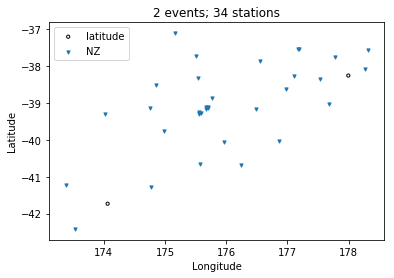

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fd1e7b01290>)

In [101]:
# map() uses source and receiver metadata to plot a very simple source-receiver map
insp.map()

(<Figure size 576x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fd1e57c8d10>)

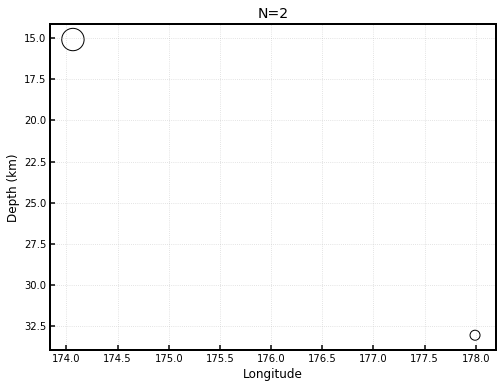

In [112]:
# event_depths() simply plots a 2D cross section of all the events at depth
insp.event_depths(xaxis="longitude")

NameError: name 'y' is not defined

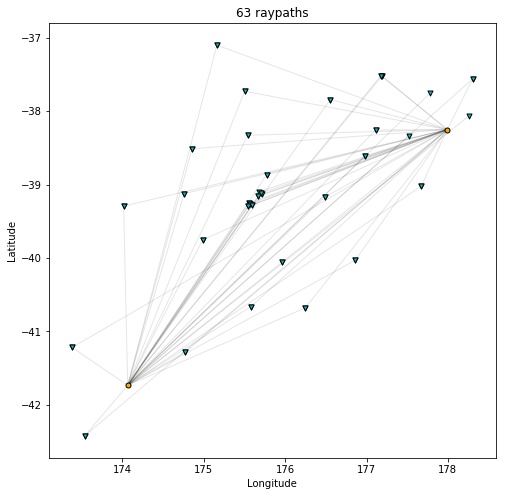

In [4]:
# raypaths() shows source-receiver connection points for any pair that has atleast one measurement
insp.raypaths(iteration="i01", step_count="s00")

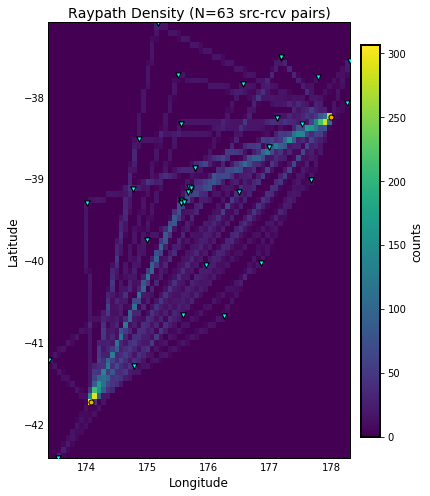

In [3]:
# raypath_density() provides a more detailed raypath plot by coloring in the density of rays. Useful 
# if you have a large number of source-receiver pairs, at which point the raypaths tend to be more difficult
# to interpret
insp.raypath_density(iteration="i01", step_count="s00")

Index(['time', 'magnitude', 'depth_km', 'latitude', 'longitude'], dtype='object')


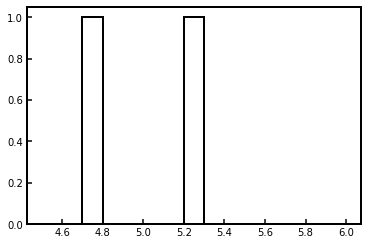

In [118]:
# event_hist() makes a simple histogram of event information based on a given source parameter
print(insp.sources.keys())
insp.event_hist(choice="magnitude")

### Measurement start times and window lengths
-----------------------------
The following plotting functions are concerned with visualizing what part of the seismic waveform 
we are measuring. These include record sections and window plots.

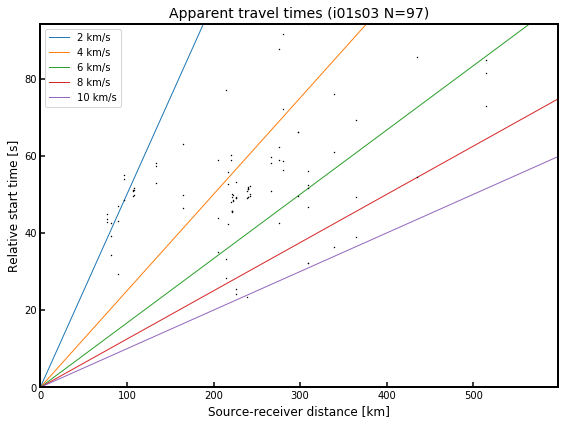

In [111]:
# travel_times() plots a proxy for phase arrivals, like a seismic record section.
# useful for inspecting potential phases of your measurements
insp.travel_times(markersize=2, t_offset=-20, constants=[2, 4, 6, 8, 10])

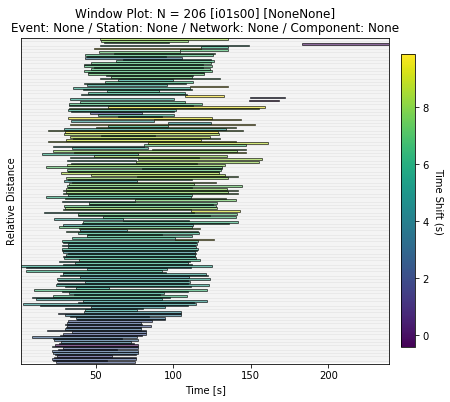

In [151]:
# plot_windows() plots the time windows against source-receiver distance to illustrate which phases are 
# included in the inversion. This was inspired by Carl Tape's PhD thesis and the LASIF plotting functionality
# showcased in Krischer et al. (2018; JGR).
insp.plot_windows(iteration="i01", step="s00")  # !!! changed 'step' to 'step_count'

### Inversion statistics
------------------------
The following plotting functions help the user understand how an inversion is progressing by comparing iterations against one another

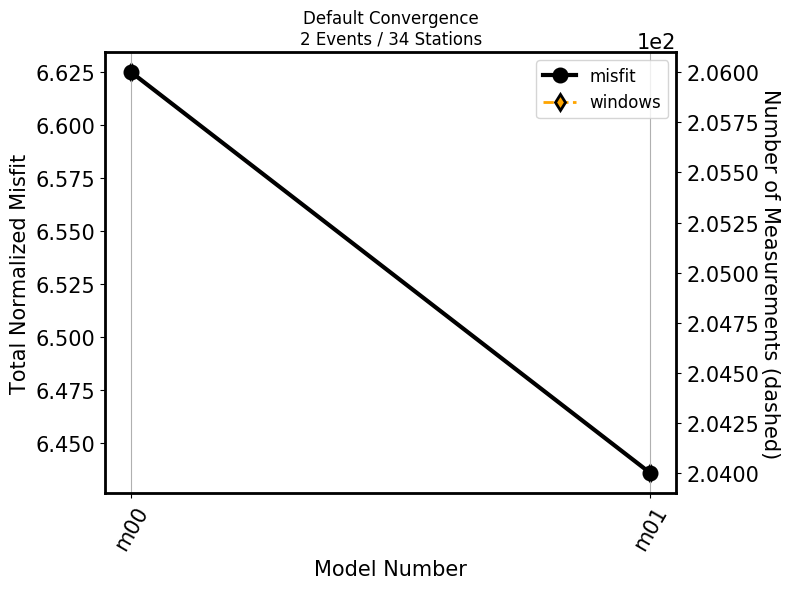

(<Figure size 800x600 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fd1dee388d0>)

In [155]:
# convergence() shows the convergence plot, or misfit reduction over the course of the inversion
# Note: because our test data only has two iterations, its convergence plot is not very illustrative.
insp.convergence(windows="nwin")

Index(['event', 'iteration', 'step', 'network', 'station', 'channel',
       'component', 'misfit', 'length_s', 'dlnA', 'window_weight',
       'max_cc_value', 'relative_endtime', 'relative_starttime',
       'cc_shift_in_seconds', 'absolute_starttime', 'absolute_endtime'],
      dtype='object')


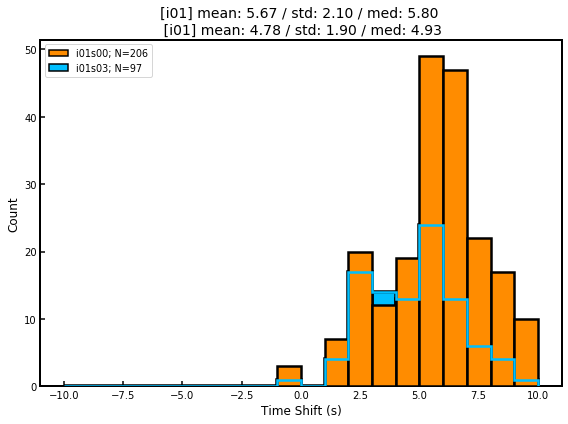

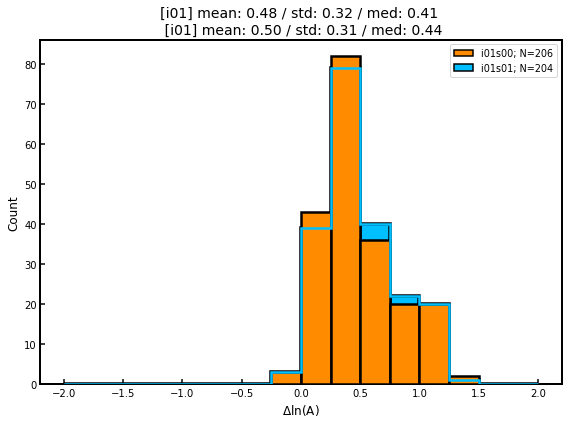

(<Figure size 576x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fd1df09df50>)

In [147]:
# hist() creates misfit histograms for all measurements comparing two evaluations (defaults to first and last)
# choices are available from any of the `windows` attributes
print(insp.windows.keys())
insp.hist(choice="cc_shift_in_seconds")
insp.hist(iteration="i01", step_count="s00", iteration_comp="i01", step_count_comp="s01", choice="dlnA")

### Measurement statistics
---------------------------
These plotting functions allow the user to plot measurements for a given evaluation in order to better understand the statistical distribution of measurements, or comparisons against one another.

Index(['event', 'iteration', 'step', 'network', 'station', 'channel',
       'component', 'misfit', 'length_s', 'dlnA', 'window_weight',
       'max_cc_value', 'relative_endtime', 'relative_starttime',
       'cc_shift_in_seconds', 'absolute_starttime', 'absolute_endtime'],
      dtype='object')


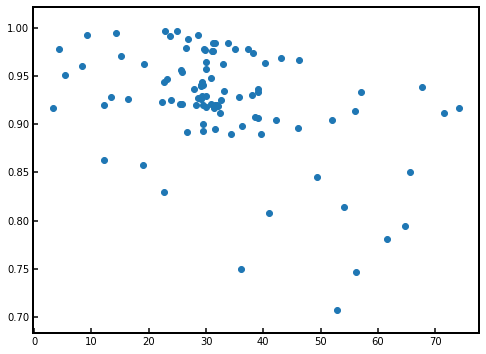

(<Figure size 576x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fd1e596fd90>)

In [108]:
# scatter() compares any two attributes in the `windows` dataframe
print(insp.windows.keys())
insp.scatter(x="relative_starttime", y="max_cc_value")

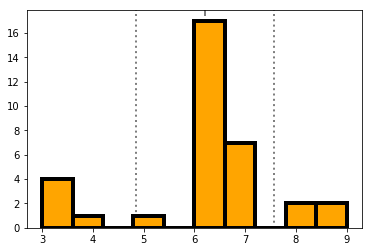

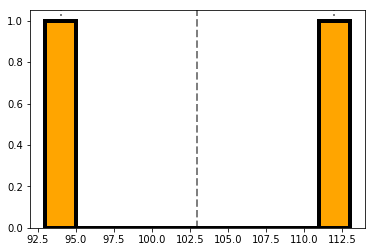

In [124]:
# measurement_hist() makes histograms of measurement numbers for 'stations' or 'event'
# Useful for identifying events or stations with outlier number of measurements
insp.measurement_hist(iteration="i01", step_count="s00", choice="station")
insp.measurement_hist(iteration="i01", step_count="s00", choice="event")

['BFZ' 'BKZ' 'ETVZ' 'FWVZ' 'HIZ' 'KHEZ' 'KHZ' 'KNZ' 'MAVZ' 'MKAZ' 'MRZ'
 'MXZ' 'NNZ' 'NTVZ' 'OPRZ' 'OTVZ' 'PXZ' 'RATZ' 'RTZ' 'TLZ' 'TMVZ' 'TOZ'
 'TRVZ' 'TSZ' 'URZ' 'VRZ' 'WAZ' 'WEL' 'WHVZ' 'WIZ' 'WSRZ' 'HAZ' 'MWZ' 'PUZ']


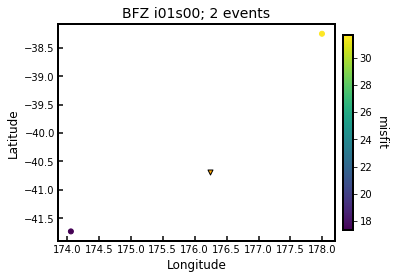

(<Figure size 432x288 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fd1e4597810>)

In [136]:
# station_event_misfit_map() creates a map for a single station. Each point that isn't the station 
# will be colored by a certain value corresponding to each event. Choices are 'nwin' or 'misfit'
print(insp.stations)
insp.station_event_misfit_map(station="BFZ", iteration="i01", step_count="s00", choice="misfit")

['2014p952799' '2013p617227']


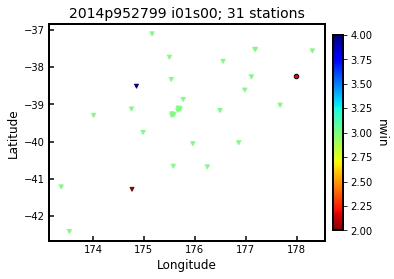

(<Figure size 432x288 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fd1df6a4e10>)

In [140]:
# event_station_misfit_map() creates a map for a single event. Each point that isn't the event 
# will be colored by a certain value corresponding to each station. Choices are 'nwin' or 'misfit'
print(insp.events)
insp.event_station_misfit_map(event="2014p952799", iteration="i01", step_count="s00", choice="nwin", cmap="jet_r")

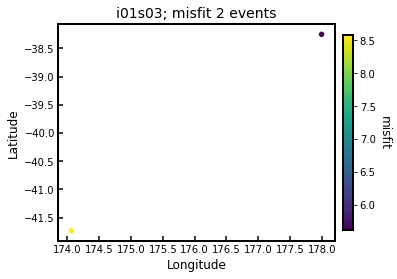

(<Figure size 432x288 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fd1df4cd1d0>)

In [142]:
# event_misfit_map() plots all events on a map and their corresponding scaled misfit value
# for a given evaluation (defaults to last evaluation in the Inspector)
insp.event_misfit_map(choice="misfit")